# Mastering Image Classification: Building a Deep Learning Model for Natural Scene Recognition

In [1]:
# Fastai modules
from fastai.vision.all import *
from fastai.metrics import error_rate

# Torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# OpenCV for image processing
import cv2

# File and path handling
import os
from pathlib import Path

# KaggleHub integration
import kagglehub

# Evaluation metrics
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix


/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/dz6/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/dz6/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [3]:
dataset_path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", dataset_path)


Path to dataset files: /Users/julia/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [4]:
path = Path(dataset_path)
train_path = path / 'seg_train' / 'seg_train'
test_path = path / 'seg_test' / 'seg_test'
pred_path = path / 'seg_pred'


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),                 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
train_data = datasets.ImageFolder(root=train_path, transform=train_transform)
test_data = datasets.ImageFolder(root=test_path, transform=val_test_transform)
pred_data = datasets.ImageFolder(root=pred_path, transform=val_test_transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
pred_loader = DataLoader(pred_data, batch_size=batch_size, shuffle=False)


In [7]:
def denormalize(image):
    image = image * 0.5 + 0.5
    return image

def visualize_augmentations(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        ax = axes[i]
        image = images[i]
        label = labels[i]

        image = denormalize(image)

        np_image = image.numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)

        ax.imshow(np_image)
        ax.axis("off")
        ax.set_title(f"Label: {label}")
    plt.show()


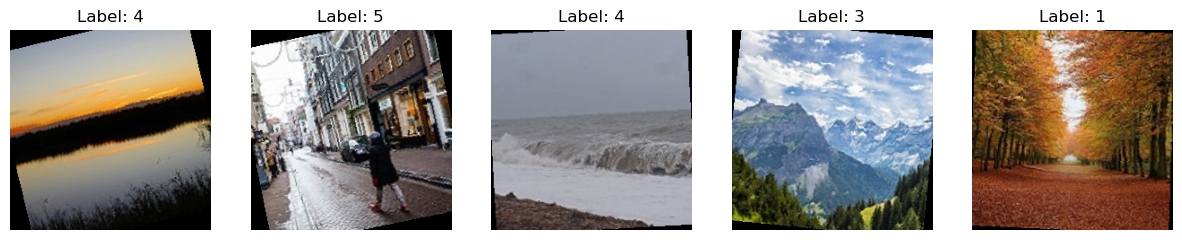

In [8]:
visualize_augmentations(train_loader)


## Building a Simple Convolutional Neural Network (CNN)

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self._calculate_flattened_size()

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def _calculate_flattened_size(self):
        dummy_input = torch.zeros(1, 3, 224, 224)  # Batch size = 1, 3 channels, 224x224
        x = self.conv1(dummy_input)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool2(x)
        self.flattened_size = x.numel()  # Total number of elements in the tensor

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = x.view(-1, self.flattened_size)  # Flatten the feature map
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x


In [10]:
num_classes = len(train_path.ls())
simple_snn = SimpleCNN(num_classes=num_classes)
simple_snn = simple_snn.to(device)


## Transfer Learning with ResNet18 Model Preparing

In [11]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

for param in resnet18.parameters():
    param.requires_grad = False

for param in resnet18.fc.parameters():
    param.requires_grad = True

resnet18 = resnet18.to(device)


/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define Loss and Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer_snn = optim.Adam(simple_snn.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(resnet18.parameters(), lr=0.0001)


## Define functions for training of models

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100. * correct / total
    return val_loss, val_accuracy
    

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path="best_model.pth"):
    best_val_accuracy = 0.0
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}  # Store metrics

    # Initialize the ReduceLROnPlateau scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

    for epoch in range(num_epochs):
        # Training step
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation step
        val_loss, val_accuracy = validate_epoch(model, val_loader, criterion, device)

        # Record metrics
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        # Check and save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Saved Best Model at Epoch {epoch+1} with Validation Accuracy: {val_accuracy:.2f}%")

        # Print metrics for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

        # Step the scheduler with validation accuracy
        scheduler.step(val_accuracy)

    print(f"Training complete. Best validation accuracy: {best_val_accuracy:.2f}%")
    return history


In [15]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Train and Save models

In [ ]:
print("\nTraining SimpleCNN...")
history_snn = train_model(simple_snn, train_loader, val_loader, criterion, optimizer_snn, num_epochs=50, device=device, save_path="simple_cnn_best.pth")
plot_metrics(history_snn)

print("\nTraining ResNet18...")
history_resnet = train_model(resnet18, train_loader, val_loader, criterion, optimizer_resnet, num_epochs=50, device=device, save_path="resnet18_best.pth")
plot_metrics(history_resnet)

/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training SimpleCNN...
Saved Best Model at Epoch 1 with Validation Accuracy: 70.18%
Epoch [1/50]
Train Loss: 0.9944, Train Accuracy: 61.75%
Validation Loss: 0.8251, Validation Accuracy: 70.18%
--------------------------------------------------
Saved Best Model at Epoch 2 with Validation Accuracy: 74.31%
Epoch [2/50]
Train Loss: 0.8005, Train Accuracy: 70.09%
Validation Loss: 0.7322, Validation Accuracy: 74.31%
--------------------------------------------------
Epoch [3/50]
Train Loss: 0.6858, Train Accuracy: 74.92%
Validation Loss: 0.7545, Validation Accuracy: 73.64%
--------------------------------------------------
Saved Best Model at Epoch 4 with Validation Accuracy: 74.92%
Epoch [4/50]
Train Loss: 0.6098, Train Accuracy: 77.82%
Validation Loss: 0.7349, Validation Accuracy: 74.92%
--------------------------------------------------
Saved Best Model at Epoch 5 with Validation Accuracy: 79.30%
Epoch [5/50]
Train Loss: 0.5534, Train Accuracy: 79.79%
Validation Loss: 0.5974, Validation A

### load saved models

In [ ]:
simple_snn = SimpleCNN(num_classes=6).to(device)
simple_snn.load_state_dict(torch.load("simple_cnn_best.pth", weights_only=True))
simple_snn.eval()

resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 6)
resnet18.load_state_dict(torch.load("resnet18_best.pth", weights_only=True))
resnet18 = resnet18.to(device)
resnet18.eval()

print("Models loaded successfully.")


In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device, dtype=next(model.parameters()).dtype)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes)
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, f1, report, cm


In [ ]:
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    

In [ ]:
print("\nEvaluating SimpleCNN on Test Dataset...")
accuracy_snn, f1_snn, report_snn, cm_snn = evaluate_model(simple_snn, test_loader, device)
print(f"SimpleCNN Accuracy: {accuracy_snn:.2f}")
print(f"SimpleCNN F1-score: {f1_snn:.2f}")
print("Classification Report:\n", report_snn)

print("\nEvaluating ResNet18 on Test Dataset...")
accuracy_resnet, f1_resnet, report_resnet, resnet_cm = evaluate_model(resnet18, test_loader, device)
print(f"ResNet18 Accuracy: {accuracy_resnet:.2f}")
print(f"ResNet18 F1-score: {f1_resnet:.2f}")
print("Classification Report:\n", report_resnet)


In [ ]:
plot_confusion_matrix(cm_snn, test_loader.dataset.classes, "SimpleCNN")

plot_confusion_matrix(resnet_cm, test_loader.dataset.classes, "ResNet18")